# 📊 Animal Complaint Analysis (2010–2015)
This notebook merges yearly 311 data from 2010 to 2015 and performs trend analysis focused on animal complaints.

- ✅ **Loading and merging** individual yearly CSV files (2010–2015)
- 🧼 **Filtering and preprocessing** to focus on animal-related complaints
- 📆 **Temporal trends**, such as monthly complaint counts
- 📍 **Spatial patterns**, including clustering and heatmap visualizations
- 📈 **Common complaint types** over time
- 📅 **Day-of-week frequency** analysis
- 🗺️ Ready for geographic visualization using **folium**
- 🧠 Extension-ready: Sociological & equity analysis or predictive modeling

This notebook is suitable for urban planning, city service optimization, or sociological research on how municipal services are requested and delivered across Boston neighborhoods.

In [36]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

# === Load and merge 2010–2015 data ===
path = "data"
csv_files = [
    "../data/2010.csv", "../data/2011.csv", "../data/2012.csv",
    "../data/2013.csv", "../data/2014.csv", "../data/2015.csv"
]
dfs = []

for file in csv_files:
    df = pd.read_csv(file, low_memory=False)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
print("Merged shape:", df.shape)


Merged shape: (893402, 30)


In [37]:
# === Parse dates and extract year/month ===
df['open_dt'] = pd.to_datetime(df['open_dt'], errors='coerce')
df.dropna(subset=['open_dt'], inplace=True)
df['year'] = df['open_dt'].dt.year
df['month'] = df['open_dt'].dt.month

# === Filter animal complaints only ===
df = df[df['type'].str.contains('animal', case=False, na=False)]
print("Filtered shape (animal complaints):", df.shape)


Filtered shape (animal complaints): (22139, 32)


In [43]:
import folium
from folium.plugins import HeatMap

# Filter to non-null coordinates
geo_df = df[['latitude', 'longitude']].dropna()

# Create a folium map centered on Boston
boston_map = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

# Add a heatmap layer
heat_data = geo_df.values.tolist()
HeatMap(heat_data, radius=8, blur=10).add_to(boston_map)

# Show the map
boston_map

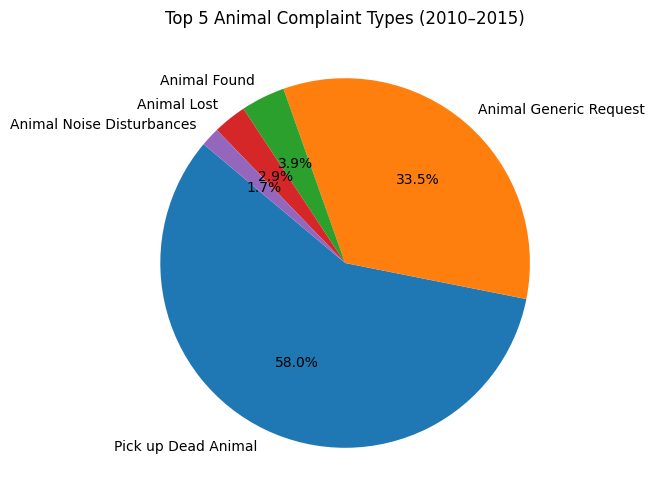

In [39]:
# === Pie Chart: Top 5 Complaint Types ===
top_types = df['type'].value_counts().nlargest(5)
top_types.plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(6, 6))
plt.title("Top 5 Animal Complaint Types (2010–2015)")
plt.ylabel("")
plt.show()


C:\Users\bukho\AppData\Local\Temp\ipykernel_37872\4265117858.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.set_index('open_dt').resample('M').size()


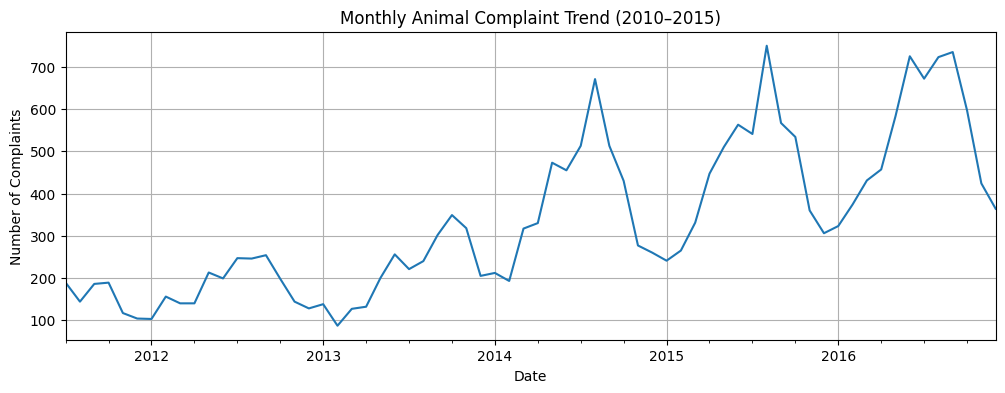

In [40]:
# === Line Plot: Monthly Complaint Trend ===
monthly_counts = df.set_index('open_dt').resample('M').size()
plt.figure(figsize=(12, 4))
monthly_counts.plot()
plt.title("Monthly Animal Complaint Trend (2010–2015)")
plt.xlabel("Date")
plt.ylabel("Number of Complaints")
plt.grid(True)
plt.show()


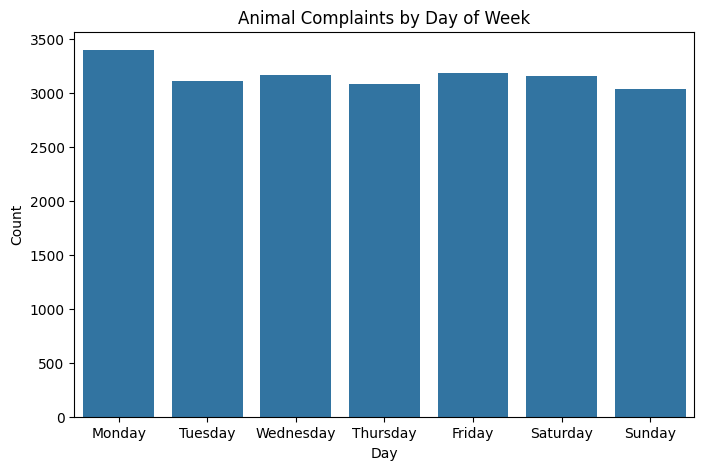

In [41]:
# === Day of Week Distribution ===
df['day_of_week'] = df['open_dt'].dt.day_name()
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='day_of_week', order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Animal Complaints by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.show()


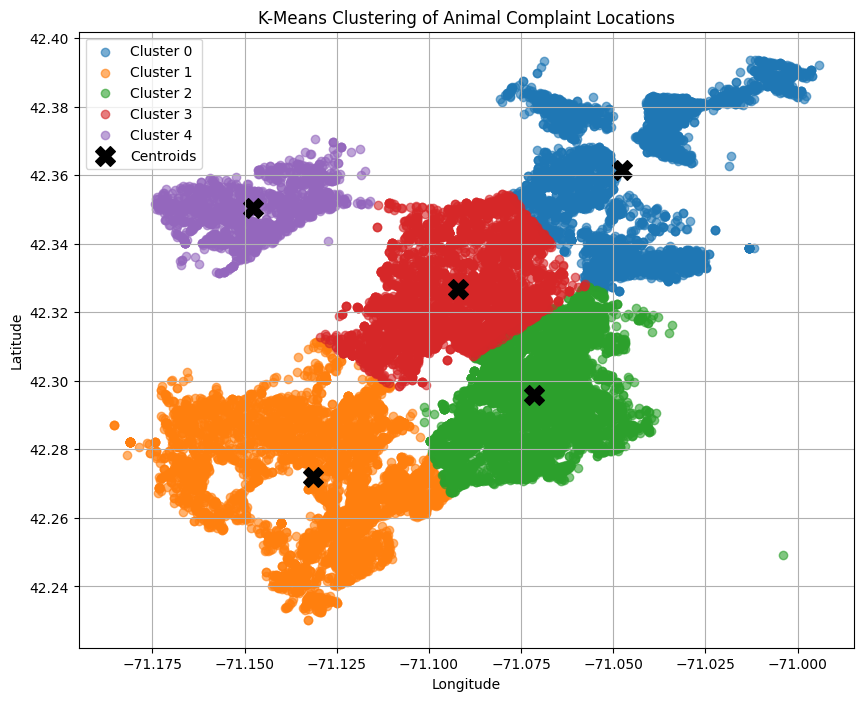

In [44]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# === Step 1: Prepare the coordinate data ===
coords = df[['latitude', 'longitude']].dropna()

# === Step 2: Run K-Means ===
k = 5  # You can experiment with 3–10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(coords)

# Add cluster labels to the dataframe
coords['cluster'] = kmeans.labels_

# === Step 3: Plot the clusters ===
plt.figure(figsize=(10, 8))
for i in range(k):
    cluster_points = coords[coords['cluster'] == i]
    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], label=f'Cluster {i}', alpha=0.6)

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], color='black', marker='X', s=200, label='Centroids')

plt.title("K-Means Clustering of Animal Complaint Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


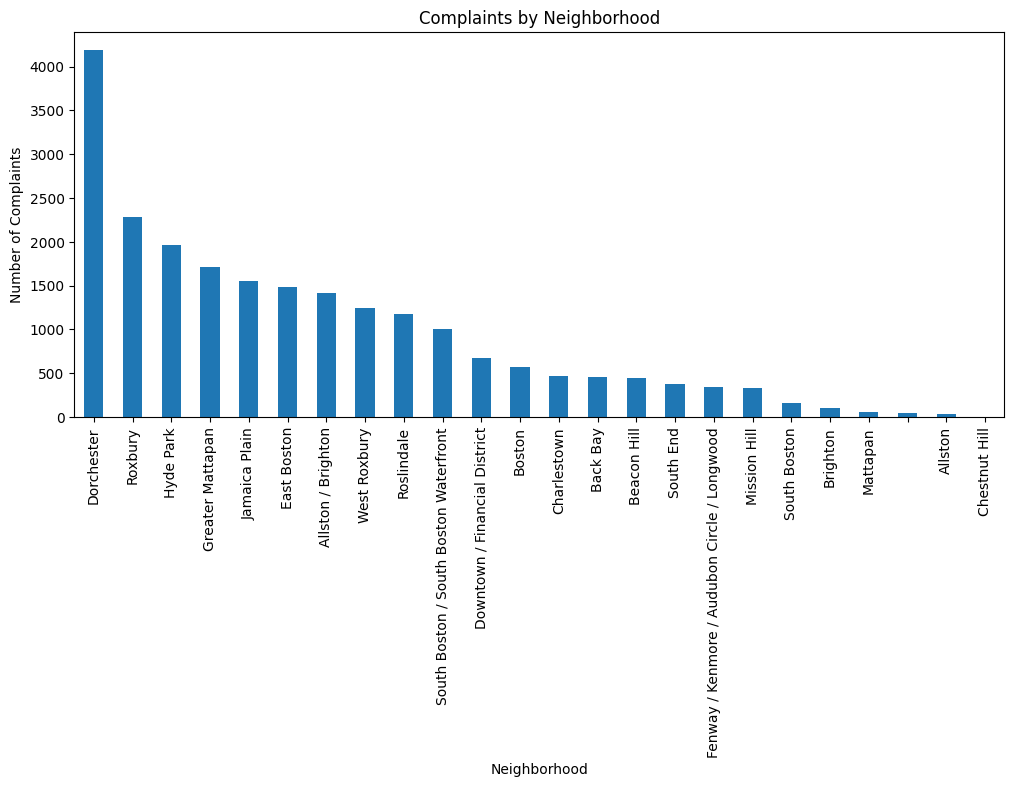

In [ ]:
neigh_counts = df['neighborhood'].value_counts().sort_values(ascending=False)
neigh_counts.plot(kind='bar', figsize=(12, 5), title="Complaints by Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Complaints")
plt.show()

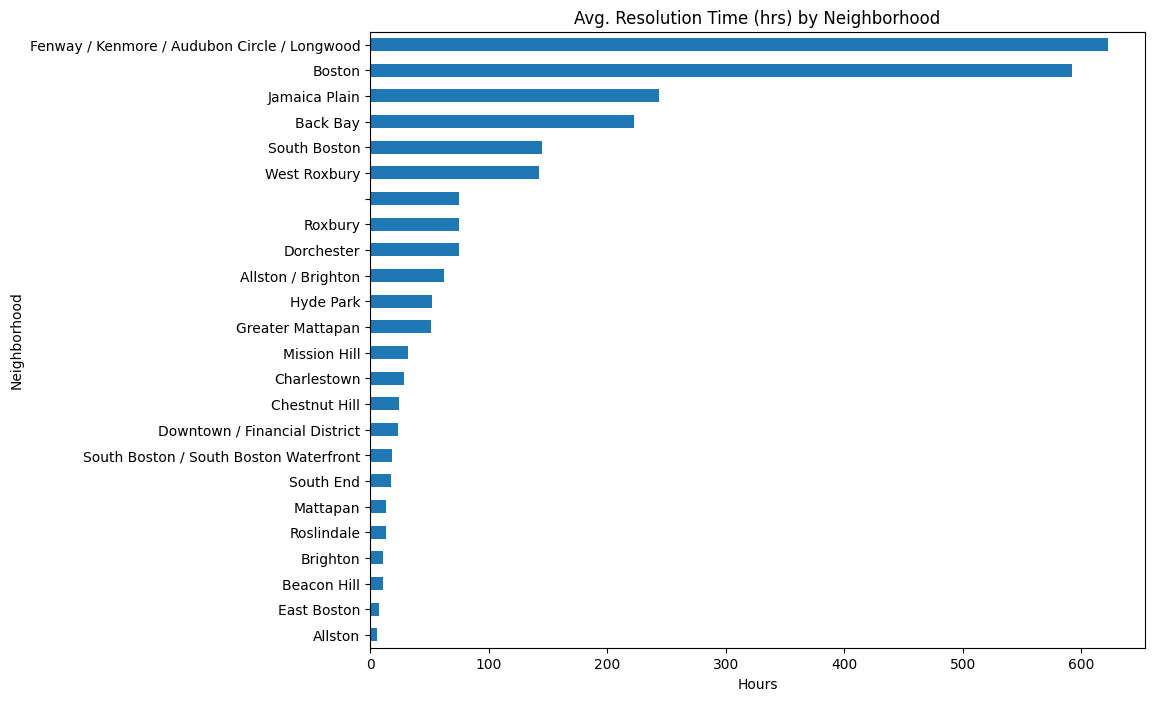

In [47]:
df['open_dt'] = pd.to_datetime(df['open_dt'], errors='coerce')
df['closed_dt'] = pd.to_datetime(df['closed_dt'], errors='coerce')
df['resolution_time'] = (df['closed_dt'] - df['open_dt']).dt.total_seconds() / 3600  # hours

res_time = df.groupby('neighborhood')['resolution_time'].mean().sort_values()
res_time.plot(kind='barh', figsize=(10, 8), title='Avg. Resolution Time (hrs) by Neighborhood')
plt.xlabel("Hours")
plt.ylabel("Neighborhood")
plt.show()



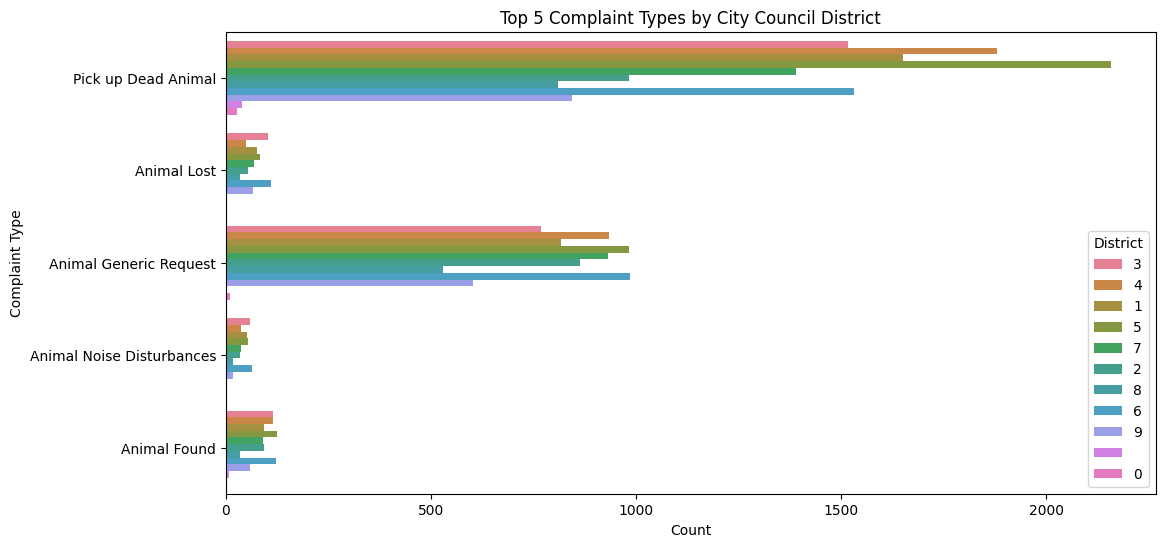

In [48]:
import seaborn as sns
top_types = df['type'].value_counts().nlargest(5).index
df_top = df[df['type'].isin(top_types)]

plt.figure(figsize=(12, 6))
sns.countplot(data=df_top, y='type', hue='city_council_district')
plt.title("Top 5 Complaint Types by City Council District")
plt.xlabel("Count")
plt.ylabel("Complaint Type")
plt.legend(title="District")
plt.show()
